 (Full) Gradient Descent (GD)
• Stochastic Gradient Descent (SGD)
• SGD with Momentum (SGDM)
• Adaptive Gradient (AdaGrad)
• RMSProp
• AdaDelta
• Adaptive Momentum (ADAM)

Describe each of the techniques in detail. Compare and contrast the relative advantages and
disadvantages of each of the techniques. Are there specific types of datasets where one technique is expected to perform better than the other? if so, why? Provide detailed justifications
for each.

Datasets: linearly separable and non-separable
https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
https://stackoverflow.com/questions/47961536/how-to-generate-linear-separable-dataset-by-using-sklearn-datasets-make-classifi

1) write logreg
2) write cost functions: 1) linear, 2) log
https://www.internalpointers.com/post/cost-function-logistic-regression
3) finish methods

In [176]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [178]:
def split(dataset, y, ratio):
    msk = np.random.rand(len(dataset)) < ratio
    return dataset[msk], dataset[~msk], y[msk], y[~msk]

In [401]:
def logreg(X, theta):
    return 1/(1+np.exp(-(X @ theta)))
              
def log_cost(pred, y):
    n = len(y)
    eps = 0.000001
    return np.sum(y*-1*np.log(pred+eps) - (1-y)*np.log(1-pred+eps))/n
                    
def lin_cost(pred, y):
    n = len(y)
    return np.sum(np.square(pred-y))/(2*n)

def predict(X, theta, y):
    label = np.round(logreg(X, theta))
    print(np.sum(label))
    return np.sum(label == y)/len(y)

In [180]:
def gd(X, y, eta, n, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    
    for i in range(n):
        #adjust theta
        pred = logreg(X, theta)
        theta = theta - eta * 1/len(y) * (X.T @ (pred-y))
    return theta

def sgd(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)

    #shuffle data
    ind = list(range(0, X.shape[0]))
    np.random.shuffle(ind)
    X = X[ind]
    y = y[ind]
    
    i=0
    while ((len(y)-i) > batch):
        sample_X = X[i:i+batch]
        sample_y = y[i:i+batch]
                     
        #adjust theta
        pred = logreg(sample_X, theta)
        theta = theta - eta * 1/batch * (sample_X.T @ (pred-sample_y))
        i += batch
    return theta

def sgdm(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    
    #shuffle data
    ind = list(range(0, X.shape[0]))
    np.random.shuffle(ind)
    X = X[ind]
    y = y[ind]
    
    i=0
    while ((len(y)-i) > batch):
        sample_X = X[i:i+batch]
        sample_y = y[i:i+batch]
        
        #get prediction
        pred = logreg(sample_X, theta)
        
        #if first time, initialize v_{t-1}
        if i == 0:
            theta = theta - eta * 1/len(sample_y) * (sample_X.T @ (pred-sample_y))
            last_v = theta
            
        #else, adjust theta
        else:
            last_v = gamma * last_v + eta * 1/len(sample_y) * (sample_X.T @ (pred-sample_y))
            theta = theta - last_v
        i += batch
    return theta

def adagrad(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    
    for i in range(n):
        #randomly select sample
        sample_ind = np.random.choice(X.shape[0], batch, replace=False)  
        sample_X = X[sample_ind]
        sample_y = y[sample_ind]

        
        #get predictions and gradients
        pred = logreg(sample_X, theta)
        
        #compute G        
        G = np.zeros((f, f))
        gradient = sample_X.T @ (pred-sample_y)
        diag += gradient**2
        temp_diag = eta/(np.sqrt(diag)+eps)
        np.fill_diagonal(G, temp_diag)
        
        #compute theta
        theta = theta - G @ gradient
        
        
    return theta

def rmsprop(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_g2 = 0 
    
    for i in range(n):
        #randomly select sample
        sample_ind = np.random.choice(X.shape[0], batch, replace=False)  
        sample_X = X[sample_ind]
        sample_y = y[sample_ind]

        
        #get predictions and gradients
        pred = logreg(sample_X, theta)
        
        #compute G       
        G = np.zeros((f, f))
        gradient = sample_X.T @ (pred-sample_y)
        prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2
        temp_diag = eta/(np.sqrt(prev_g2)+eps)
        np.fill_diagonal(G, temp_diag)
        
        #compute theta
        theta = theta - G @ gradient
        
    return theta

def adadelta(X, y, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_e_delta = 0 
    prev_g2 = 0
    prev_delta = 0
    
    for i in range(n):
        #randomly select sample
        sample_ind = np.random.choice(X.shape[0], batch, replace=False)  
        sample_X = X[sample_ind]
        sample_y = y[sample_ind]
        
        #get predictions and gradients
        pred = logreg(sample_X, theta)
        
        #compute rms_g
        gradient = sample_X.T @ (pred-sample_y)
        prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2 
        rms_g = np.sqrt(prev_g2+eps)
        
       
        #compute rms_delta
        e_delta = gamma*prev_e_delta+(1-gamma)*prev_delta**2
        prev_e_delta = e_delta
        rms_delta = np.sqrt(e_delta+eps)
        
        #get weights
        prev_delta = -1*rms_delta/rms_g * gradient
        theta = theta + prev_delta
        
    return theta 

def adam(X, y, eta, n, batch, b_1, b_2, log=True):
    f = X.shape[1]
    theta = np.zeros(f)
    eps = 0.0000001
    m = 0
    v = 0
    
    for i in range(n):
        #randomly select sample
        sample_ind = np.random.choice(X.shape[0], batch, replace=False)  
        sample_X = X[sample_ind]
        sample_y = y[sample_ind]
        
        #get predictions and gradients
        pred = logreg(sample_X, theta)
        gradient = sample_X.T @ (pred-sample_y)
    
        m = b_1*m+(1-b_1)*gradient
        v = b_2*v+(1-b_2)*(gradient**2)
        

        m_hat = m/(1-b_1**(n+1))
        v_hat = v/(1-b_2**(n+1))
        theta = theta - eta / (np.sqrt(v_hat) + eps) * m_hat
    return theta

# Get data

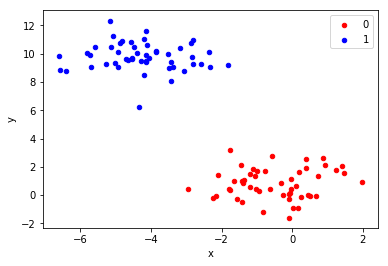

In [423]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2)
X = np.hstack((np.ones((len(y),1)),X))
df = pd.DataFrame(dict(x=X[:,1], y=X[:,2], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [425]:
train_X, test_X, train_y, test_y= split(X, y, 0.7)

In [427]:
# total = [1*i for i in range(1, 10)]
total = [10]
eta = 0.1
eta_rms = 0.001
batch =5
gamma = 0.9
gamma_sgdm = 0.1
b_1 = 0.9
b_2 = 0.999

train_perf_acc = []
test_perf_acc = []
for n in total:
    print("On #" + str(n))
    gd_theta = gd(train_X, train_y, eta, n)
    sgd_theta = sgd(train_X, train_y, eta, n, batch)
    sgdm_theta = sgdm(train_X, train_y, eta, gamma_sgdm, n, batch)
    adagrad_theta = adagrad(train_X, train_y, eta, n, batch)
    rmsprop_theta = rmsprop(train_X, train_y, eta_rms, gamma, n, batch)
    adadelta_theta = adadelta(train_X, train_y, gamma, n, batch)
    adam_theta = adam(train_X, train_y, eta, n, batch, b_1, b_2)
    print(gd_theta, sgd_theta)

    train_perf_acc.append([predict(train_X, gd_theta, train_y), predict(train_X, sgd_theta, train_y), \
                       predict(train_X, sgdm_theta, train_y), predict(train_X, adagrad_theta, train_y), \
                       predict(train_X, rmsprop_theta, train_y), predict(train_X, adadelta_theta, train_y), \
                       predict(train_X, adam_theta, train_y)])
                      
    test_perf_acc.append([predict(test_X, gd_theta, test_y), predict(test_X, sgd_theta, test_y), \
                       predict(test_X, sgdm_theta, test_y), predict(test_X, adagrad_theta, test_y), \
                       predict(test_X, rmsprop_theta, test_y), predict(test_X, adadelta_theta, test_y), \
                       predict(test_X, adam_theta, test_y)])


On #10
[-0.21188242 -0.09685919  0.26613297] [-0.21545496 -0.13967204  0.22079316]
55.0
55.0
55.0
39.0
62.0
61.0
51.0
24.0
24.0
24.0
21.0
28.0
25.0
24.0


In [250]:
names = ["GD", "SGD", "SGDM", "adagrad", "rmsprop", "adadelta", "adam"]

In [379]:
-X @ gd_theta

array([ 4.85311119, -6.61095417,  7.17780403,  4.81063632, -8.98027356,
       -8.42818332,  7.58676649, -6.97226714, -8.46970926, -7.57772323,
       -6.47069102, -7.10618574,  4.99084319,  5.85974212, -7.11984039,
       -8.35764628, -8.55656801,  5.10327438,  7.69561265,  5.2951221 ,
       -8.28237079,  4.61508807, -8.21035921,  6.24968095,  5.65859197,
       -8.83167932, -6.82711293,  5.02128009,  6.0715841 ,  6.90768664,
        8.29389006,  5.82699263, -7.4707867 ,  6.07118112,  8.06458925,
        5.21294014, -7.95946242, -7.84682656,  6.59617972, -8.10712149,
       -8.20402559,  5.07784284, -7.42099421, -7.29713221,  5.8901679 ,
       -7.74314356, -7.6782332 , -5.41116377, -6.63332117, -9.1228901 ,
       -7.13591618, -6.55665961, -7.56046035,  7.19686793,  6.89017603,
        4.81975213,  6.11626676,  4.25889459,  7.25956377, -8.85167971,
       -5.95145655,  4.7690895 ])

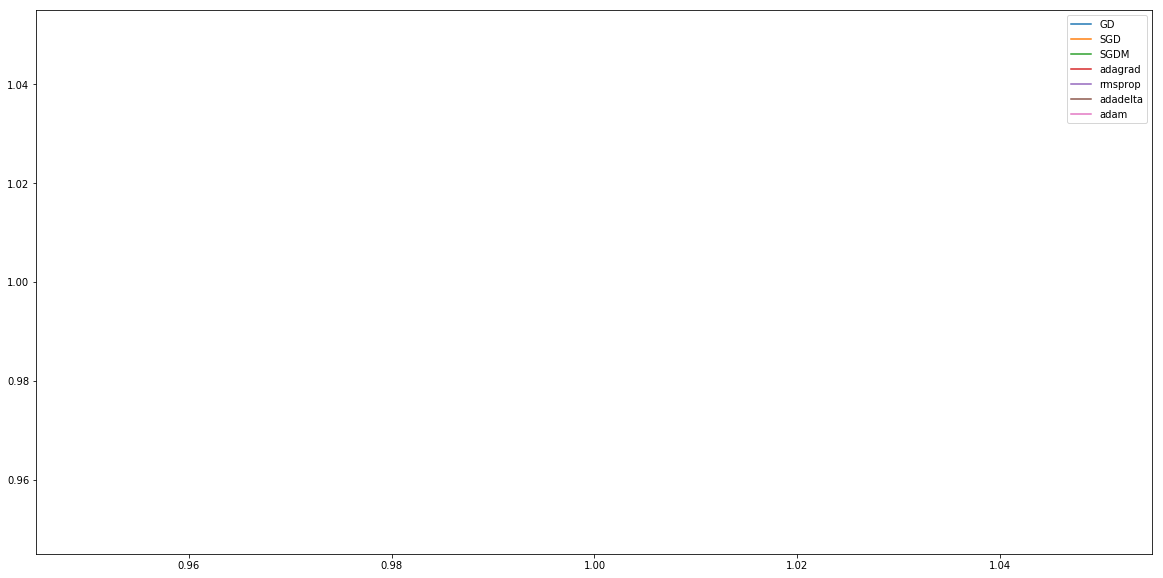

In [285]:
x_acc = total
fig, ax = plt.subplots(figsize=(20, 10))
train_perf_acc = np.array(train_perf_acc)
test_perf_acc = np.array(test_perf_acc)
lines_train_acc = [train_perf_acc[:, i] for i in range(7)]
lines_test_acc = [test_perf_acc[:, i] for i in range(7)]
# plt.plot(total, lines_train_acc, label=names)
# plt.plot(total, lines_test_acc, label=names)
# plt.plot(x_p, y_p6, label="adadelta")
# plt.plot(x_p, y_p7, label="adam")

for i,l in zip(lines_train_acc,names):  
    plt.plot(x_acc,i,label='l')
    plt.legend(names)    
plt.show()

In [376]:
n = 100

eta = 0.1
eta_rms = 0.001
batch = 1
gamma = 0.9
gamma_sgdm = 0.1
b_1 = 0.9
b_2 = 0.999

gd_theta = gd(train_X, train_y, eta, n)
print("GD Theta: " + str(gd_theta))
sgd_theta = sgd(train_X, train_y, eta, n, batch)
print("SGD Theta: " + str(sgd_theta))
sgdm_theta = sgdm(train_X, train_y, eta, gamma_sgdm, n, batch)
print("SGDM Theta: " + str(sgd_theta))

adagrad_theta = adagrad(train_X, train_y, eta, n, batch)
print("adagrad Theta: " + str(adagrad_theta))

rmsprop_theta = rmsprop(train_X, train_y, eta_rms, gamma, n, batch)
print("rmsprop Theta: " + str(rmsprop_theta))

adadelta_theta = adadelta(train_X, train_y, gamma, n, batch)
print("adadelta Theta: " + str(adadelta_theta))

adam_theta = adam(train_X, train_y, eta, n, batch, b_1, b_2)
print("adam Theta: " + str(adam_theta))


gd_acc = predict(train_X, gd_theta, train_y)
print("GD Acc: " + str(gd_acc))
sgd_acc = predict(train_X, sgd_theta, train_y)
print("SGD Acc: " + str(sgd_acc))
sgdm_acc = predict(train_X, sgdm_theta, train_y)
print("SGDM Acc: " + str(sgdm_acc))
adagrad_acc = predict(train_X, adagrad_theta, train_y)
print("adagrad Acc: " + str(adagrad_acc))
rmsprop_acc = predict(train_X, rmsprop_theta, train_y)
print("rmsprop Acc: " + str(rmsprop_acc))
adadelta_acc = predict(train_X, adadelta_theta, train_y)
print("adadelta Acc: " + str(adadelta_acc))
adam_acc = predict(train_X, adam_theta, train_y)
print("adam Acc: " + str(adam_acc))

gd_acc = predict(test_X, gd_theta, test_y)
print("GD Acc: " + str(gd_acc))
sgd_acc = predict(test_X, sgd_theta, test_y)
print("SGD Acc: " + str(sgd_acc))
sgdm_acc = predict(test_X, sgdm_theta, test_y)
print("SGDM Acc: " + str(sgdm_acc))
adagrad_acc = predict(test_X, adagrad_theta, test_y)
print("adagrad Acc: " + str(adagrad_acc))
rmsprop_acc = predict(test_X, rmsprop_theta, test_y)
print("rmsprop Acc: " + str(rmsprop_acc))
adadelta_acc = predict(test_X, adadelta_theta, test_y)
print("adadelta Acc: " + str(adadelta_acc))
adam_acc = predict(test_X, adam_theta, test_y)
print("adam Acc: " + str(adam_acc))

GD Theta: [-0.85910553  0.1380704 ]
SGD Theta: [-0.89572458  0.0470759 ]
SGDM Theta: [-0.89572458  0.0470759 ]
adagrad Theta: [-0.57913067  0.24801919]
rmsprop Theta: [-0.10411655  0.0321563 ]
adadelta Theta: [-0.09826178  0.03664745]
adam Theta: [-1.64154393  0.67008633]
32.0
GD Acc: 1.0
32.0
SGD Acc: 1.0
32.0
SGDM Acc: 1.0
32.0
adagrad Acc: 1.0
32.0
rmsprop Acc: 1.0
32.0
adadelta Acc: 1.0
32.0
adam Acc: 1.0
18.0
GD Acc: 1.0
18.0
SGD Acc: 1.0
18.0
SGDM Acc: 1.0
18.0
adagrad Acc: 1.0
18.0
rmsprop Acc: 1.0
18.0
adadelta Acc: 1.0
18.0
adam Acc: 1.0


In [420]:
n = 1000
eta = 1
    #set-up
X = train_X
y = train_y
f = X.shape[1]
theta = np.zeros(f)

for i in range(n):
    #adjust theta
    pred = logreg(X, theta)
    theta = theta - eta * 1/len(y) * (X.T @ (pred-y))
    print(theta)


[-0.81644636 -2.23274583]
[-0.81131284 -2.23908116]
[-0.80633255 -2.24523183]
[-0.80149657 -2.25120853]
[-0.79679677 -2.25702102]
[-0.79222565 -2.26267827]
[-0.78777636 -2.26818852]
[-0.78344254 -2.27355938]
[-0.77921834 -2.27879787]
[-0.77509836 -2.2839105 ]
[-0.77107755 -2.28890329]
[-0.76715126 -2.29378185]
[-0.76331513 -2.29855141]
[-0.75956511 -2.30321683]
[-0.75589743 -2.30778266]
[-0.75230853 -2.31225315]
[-0.74879511 -2.31663229]
[-0.74535405 -2.32092382]
[-0.74198244 -2.32513124]
[-0.73867752 -2.32925787]
[-0.73543671 -2.33330682]
[-0.73225757 -2.33728102]
[-0.7291378  -2.34118325]
[-0.72607522 -2.34501611]
[-0.72306777 -2.3487821 ]
[-0.72011351 -2.35248355]
[-0.71721059 -2.3561227 ]
[-0.71435726 -2.35970164]
[-0.71155186 -2.36322239]
[-0.7087928  -2.36668685]
[-0.70607858 -2.37009683]
[-0.70340777 -2.37345406]
[-0.700779   -2.37676019]
[-0.69819098 -2.38001678]
[-0.69564246 -2.38322533]
[-0.69313226 -2.38638727]
[-0.69065924 -2.38950396]
[-0.68822233 -2.39257672]
[-0.68582049

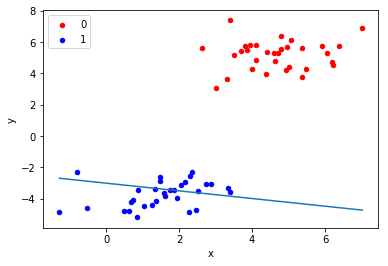

In [421]:
df = pd.DataFrame(dict(x=train_X[:,0], y=train_X[:,1], label=train_y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

x_p = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
y_p = theta[1] + theta[0]* x_p
plt.plot(x_p, y_p)
plt.show()

In [403]:
n = 300
batch = 3
eta = 0.1
    #set-up
X = train_X
y = train_y
f = X.shape[1]
theta = np.zeros(f)
    
for i in range(300):
    ind = list(range(0, X.shape[0]))
    np.random.shuffle(ind)
    X = X[ind]
    y = y[ind]
    for j in range(len(ind)):
        #adjust theta
        theta = theta - (eta) * (X[j].T @ np.array([logreg(X[j], theta) - y[j]])) 
        print(theta)

ValueError: shapes (2,) and (1,) not aligned: 2 (dim 0) != 1 (dim 0)

In [336]:
acc = predict(test_X, theta, test_y)
print("Acc: " + str(acc))

11.0
Acc: 0.9333333333333333


In [337]:
test_y.sum()

11

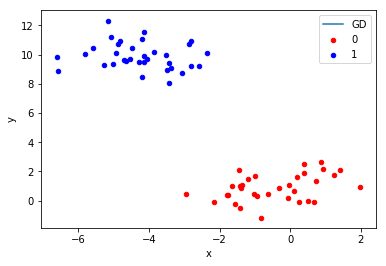

In [432]:
df = pd.DataFrame(dict(x=train_X[:,1], y=train_X[:,2], label=train_y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

x_p = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
y_p =gd_theta[1]/gd_theta[2] + gd_theta[1]/gd_theta[2]* x_p
# y_p2 =sgd_theta[1] + sgd_theta[0]* x_p
# y_p3 =sgdm_theta[1] + sgdm_theta[0]* x_p
# y_p4 =adagrad_theta[1] + adagrad_theta[0]* x_p
# y_p5 =rmsprop_theta[1] + rmsprop_theta[0]* x_p
# y_p6 =adadelta_theta[1] + adadelta_theta[0]* x_p
# y_p7 =adam_theta[1] + adam_theta[0]* x_p
plt.plot(x_p, y_p, label="GD")
# plt.plot(x_p, y_p2, label="SGD")
# plt.plot(x_p, y_p3, label="SGDM")
# plt.plot(x_p, y_p4, label="adagrad")
# plt.plot(x_p, y_p5, label="rmsprop")
# plt.plot(x_p, y_p6, label="adadelta")
# plt.plot(x_p, y_p7, label="adam")
plt.legend()
plt.show()

In [417]:
from sklearn.linear_model import LogisticRegression
l = LogisticRegression().fit(train_X, train_y)
l.intercept_

C:\Users\janep\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([-0.06191493])

C:\Users\janep\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}